In [193]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim

In [194]:
LOAD_CHECKPOINT = False
checkpoint_name = ''
checkpoint = {}

In [195]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

## Hyperparameters

In [196]:
lr = 1e-3
batch_size = 8
num_cores = 4

## Data Setup

In [197]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomGrayscale(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [198]:
data_dir = 'mmod_images'

datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=num_cores)
               for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
class_names = datasets['train'].classes

In [199]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

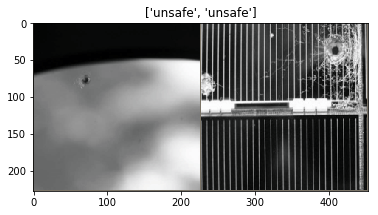

In [216]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Helpers

In [142]:
def train(model, lossFunc, optimizer, history, checkpoint_every, num_epochs):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0
            num_correct = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunc(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                epoch_loss += loss.item() * inputs.size(0)
                num_correct += torch.sum(preds == labels.data)
            
            epoch_loss = epoch_loss / dataset_sizes[phase]
            epoch_acc = num_correct.double() / dataset_sizes[phase]
            
            if phase == 'train':
                history.add_train_loss(epoch_loss)
                history.add_train_acc(epoch_acc)
            else:
                history.add_val_loss(epoch_loss)
                history.add_val_acc(epoch_acc)
                
        if (epoch + 1) % checkpoint_every == 0:
            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')
            save(model=model, optimzer=optimizer, epoch_num=epoch+1,
                 lossFunc=lossFunc, history=history, arch=MODEL_ARCH)
    return model, optimizer, history

In [202]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [203]:
class History():
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        
    def add_train_loss(self, l):
        self.train_loss.append(l)
    
    def add_val_loss(self, l):
        self.val_loss.append(l)
        
    def add_train_acc(self, a):
        self.train_acc.append(a)
    
    def add_val_acc(self, a):
        self.val_acc.append(a)

## Save/Load

In [204]:
def save(model, optimzer, epoch_num, lossFunc, history, arch):
    checkpoint = { \
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lossFunc': str(loss)[:-2],
        'train_loss': history.train_loss,
        'val_loss': history.val_loss,
        'arch': arch
    }
    PATH = str(optimizer).split(' ')[0] 
    PATH += '_' + checkpoint['lossFunc']
    PATH += '_' + str(epoch_num)
    PATH += '_' + arch
    PATH += '_' + '%.3f'%(history.train_loss[-1])
    PATH += '_' + '%.3f'%(history.val_loss[-1])
    try:
        os.mkdir('checkpoints')
    except FileExistsError:
        pass
    PATH = os.path.join('checkpoints', PATH + 'ptc')
    torch.save(checkpoint, PATH)

In [205]:
if LOAD_CHECKPOINT:
    PATH = os.join('checkpoints', checkpoint_name + '.ptc')
    checkpoint = torch.load(PATH)

## Train

In [206]:
# training setup
checkpoint_every = 10 
num_epochs = 40

In [207]:
# downloads fully trained resnet18 model on first call
model = models.resnet34(pretrained=True)
MODEL_ARCH = 'resnet34'
# reset final layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters())
history = History()

if LOAD_CHECKPOINT:
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    history.train_loss = checkpoint['train_loss']
    history.val_loss = checkpoint['val_loss']

In [209]:
test_model, optimizer, history = train(model, loss, optimizer, history, 
                                       checkpoint_every, num_epochs=5)

Epoch 1
train Loss: 1.477278470993042 Acc: 0.0
val Loss: 0.6072909235954285 Acc: 1.0
Epoch 2
train Loss: 0.272457093000412 Acc: 1.0
val Loss: 1.4252339601516724 Acc: 0.0
Epoch 3
train Loss: 0.7413725256919861 Acc: 0.5
val Loss: 0.0 Acc: 1.0
Epoch 4
train Loss: 0.20204512774944305 Acc: 1.0
val Loss: 0.0 Acc: 1.0
Epoch 5
train Loss: 0.01722782850265503 Acc: 1.0
val Loss: 0.007169008255004883 Acc: 1.0


## Test 

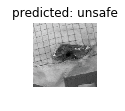

In [210]:
visualize_model(model)